<table class="table table-bordered">
    <tr>
        <th style="text-align:center; width:25%"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 250px; height: 125px; "></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Assignment 2 (Problem 1) - Sentiment Analysis Model  (Group)</h2><h3>AY2021/22 Semester</h3></th>
    </tr>
</table>

In [1]:
# Import the Required Packages
from tensorflow import keras
print('keras: ', keras.__version__)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import os

from tensorflow.keras import preprocessing
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SimpleRNN

keras:  2.2.4-tf


## Step 1 – Data Loading and Processing (Group)

### 1.1 Data Loading

In [2]:
# Loading data from CSV file
dat = pd.read_csv('spotify_reviews.csv')

In [3]:
dat.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOEE7tdqJ-kSHMQtB7drb8K0GZ3gPKagzSlCMKz...,David Slinkard,https://play-lh.googleusercontent.com/a-/AOh14...,Offline mode is terrible and honestly barely e...,2,181,8.6.48.796,2021-08-03 23:00:58,NaN,NaN
1,gp:AOqpTOF8rjBgB-QS2YpFbdm2Yl-fFyaMPF3XX2Z_CSl...,hailey marie,https://play-lh.googleusercontent.com/a-/AOh14...,"yeah, they have good songs & alot of options, ...",1,714,8.6.48.796,2021-08-02 17:37:44,NaN,NaN
2,gp:AOqpTOGMPgJY5WJ3oyLkW9agfUdIvPiqO2kzsXMi2Oe...,john vanderweide,https://play-lh.googleusercontent.com/a/AATXAJ...,This app used to be amazing. It's dipped in qu...,3,16,8.6.48.796,2021-08-04 20:39:37,NaN,NaN
3,gp:AOqpTOFMxPkp1wO8bFlJF7L2HEhExjX88_Rg0HL4a1Z...,Driskon,https://play-lh.googleusercontent.com/a-/AOh14...,"Spotify is a good app, and I've used it for tw...",5,483,8.6.48.796,2021-08-03 14:05:25,NaN,NaN
4,gp:AOqpTOGNBH058eBjb4iScFt8-SW3f0HyZHMGv49vPJC...,Devan Hoffer,https://play-lh.googleusercontent.com/a/AATXAJ...,Probably one of the least reliable streaming a...,2,15,8.6.48.796,2021-08-05 00:05:06,NaN,NaN


In [4]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98589 entries, 0 to 98588
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              98589 non-null  object
 1   userName              98589 non-null  object
 2   userImage             98589 non-null  object
 3   content               98589 non-null  object
 4   score                 98589 non-null  int64 
 5   thumbsUpCount         98589 non-null  int64 
 6   reviewCreatedVersion  98589 non-null  object
 7   at                    98589 non-null  object
 8   replyContent          893 non-null    object
 9   repliedAt             893 non-null    object
dtypes: int64(2), object(8)
memory usage: 7.5+ MB


In [5]:
dat['score'].value_counts()

1    36319
5    18610
2    17318
3    14544
4    11798
Name: score, dtype: int64

In [6]:
# Dropping duplicates in the data
dat = dat.drop_duplicates(subset=['content'])

In [7]:
# Converting content frame into string instead of object
dat['content']= dat['content'].apply(str)

### 1.2 Data Processing


In [8]:
import nltk

stopwords = nltk.corpus.stopwords.words('english')

In [9]:
# Function for cleansing data
def pre_process(text):
    
    # remove stopwords
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stopwords]
    
    # remove punctuation
    text = " ".join([word for word in text if word not in string.punctuation])
    
    # lower text
    text=text.lower()
    
    return text

dat['content_cleaned'] = dat['content'].apply(lambda x:pre_process(x))

In [10]:
dat['content_cleaned']

0        offline mode terrible honestly barely even wor...
1        yeah good songs alot options ads situation got...
2        this app used amazing it dipped quality lot es...
3        spotify good app i used two years premium almo...
4        probably one least reliable streaming apps sho...
                               ...                        
46392    good app music shows much ads free version pas...
46393    lately i trouble connecting app i need keeo cl...
46394    the best ever aap sorry gaana far better ads r...
46395    it doesnt let log anymore facebook website let...
46396                  i issues app past 2 3 years i using
Name: content_cleaned, Length: 22199, dtype: object

In [11]:
X, y = (dat['content_cleaned'].values, dat['score'].values)

In [12]:
# Tokenizing the content
tk = Tokenizer()
tk.fit_on_texts(X)
X_seq = tk.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=30, padding='post')

In [13]:
y = dat['score'].map( {1: 0, 2: 1, 3: 2, 4: 3, 5: 4} ).to_numpy()

### 1.3 Data Sampling

In [14]:
# Split the X & y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2)

## Step 2 – Develop a Sentiment Analysis Model (Individual: One Model Per Student)

### Using GloVe Embeddings

In [15]:
glove_dir = 'C:/Users/Brayden/Documents/NP CSF/Year 2 Semester 1/DL/Week 11/glove.6B/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.50d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [16]:
word_index = tk.word_index
max_features = len(tk.word_counts.keys())+1
maxlen = 30
embedding_dim = 50

embedding_matrix = np.zeros((max_features, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_features:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [17]:
print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.11891     0.15255    -0.082073   ... -0.57511997 -0.26671001
   0.92120999]
 [ 0.40037    -0.79645002  1.37629998 ...  0.18685     1.05229998
   0.38187   ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


### Base Model 1

In [208]:
# Build the Model
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
model.add(LSTM(256, return_sequences=True))
model.add(LSTM(256, return_sequences=True))
model.add(GRU(256))
model.add(Dense(5, activation='softmax'))

model.layers[0].set_weights([embedding_matrix])
#model.layers[0].trainable = False

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 30, 50)            758750    
_________________________________________________________________
lstm_66 (LSTM)               (None, 30, 256)           314368    
_________________________________________________________________
lstm_67 (LSTM)               (None, 30, 256)           525312    
_________________________________________________________________
gru_34 (GRU)                 (None, 256)               394752    
_________________________________________________________________
dense_34 (Dense)             (None, 5)                 1285      
Total params: 1,994,467
Trainable params: 1,994,467
Non-trainable params: 0
_________________________________________________________________


In [209]:
# Train the Model
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2)

Train on 14207 samples, validate on 3552 samples
Epoch 1/20


14207/14207 [==============================] - 26s 2ms/sample - loss: 1.3036 - acc: 0.4969 - val_loss: 1.3204 - val_acc: 0.4716
Epoch 2/20
14207/14207 [==============================] - 12s 852us/sample - loss: 1.1726 - acc: 0.5395 - val_loss: 1.2511 - val_acc: 0.5245
Epoch 3/20
14207/14207 [==============================] - 13s 922us/sample - loss: 1.1164 - acc: 0.5552 - val_loss: 1.2769 - val_acc: 0.5177
Epoch 4/20
14207/14207 [==============================] - 13s 905us/sample - loss: 1.0713 - acc: 0.5675 - val_loss: 1.2498 - val_acc: 0.5079
Epoch 5/20
14207/14207 [==============================] - 13s 915us/sample - loss: 1.0334 - acc: 0.5858 - val_loss: 1.1556 - val_acc: 0.5318
Epoch 6/20
14207/14207 [==============================] - 14s 974us/sample - loss: 0.9992 - acc: 0.5972 - val_loss: 1.1639 - val_acc: 0.5290
Epoch 7/20
14207/14207 [==============================] - 12s 869us/sample - loss: 0.9590 - acc: 0.6109 - val_loss: 1.1932 - val_acc: 0.5282
Epoch 8/20
14207/14207 [==

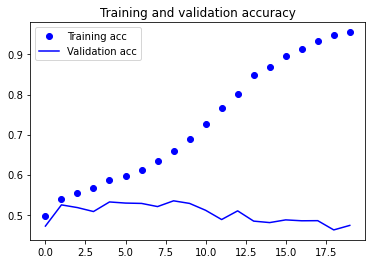

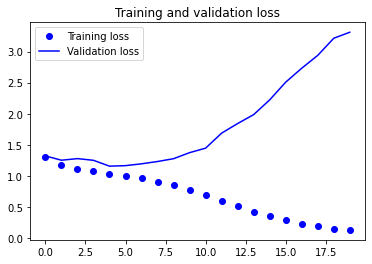

In [210]:
# Plot the Training and Validation Accuracy & Loss Scores
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Base Model 2 

In [23]:
# Build the Model
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
model.add(LSTM(16, return_sequences=True))
model.add(LSTM(16, return_sequences=True))
model.add(GRU(16))
model.add(Dense(5, activation='softmax'))

model.layers[0].set_weights([embedding_matrix])
#model.layers[0].trainable = False

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 50)            758750    
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 16)            4288      
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 16)            2112      
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                1632      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 85        
Total params: 766,867
Trainable params: 766,867
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Train the Model
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2)

Train on 14207 samples, validate on 3552 samples
Epoch 1/20


14207/14207 [==============================] - 35s 2ms/sample - loss: 1.2939 - acc: 0.4966 - val_loss: 1.2105 - val_acc: 0.5211
Epoch 2/20
14207/14207 [==============================] - 18s 1ms/sample - loss: 1.1764 - acc: 0.5335 - val_loss: 1.2006 - val_acc: 0.5239
Epoch 3/20
14207/14207 [==============================] - 16s 1ms/sample - loss: 1.1315 - acc: 0.5457 - val_loss: 1.1523 - val_acc: 0.5239
Epoch 4/20
14207/14207 [==============================] - 15s 1ms/sample - loss: 1.0938 - acc: 0.5571 - val_loss: 1.1410 - val_acc: 0.5318
Epoch 5/20
14207/14207 [==============================] - 15s 1ms/sample - loss: 1.0645 - acc: 0.5664 - val_loss: 1.1517 - val_acc: 0.5189
Epoch 6/20
14207/14207 [==============================] - 14s 981us/sample - loss: 1.0361 - acc: 0.5773 - val_loss: 1.1495 - val_acc: 0.5251
Epoch 7/20
14207/14207 [==============================] - 14s 968us/sample - loss: 1.0086 - acc: 0.5867 - val_loss: 1.1580 - val_acc: 0.5369
Epoch 8/20
14207/14207 [==========

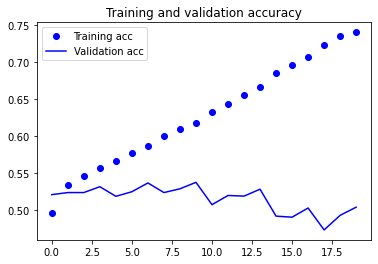

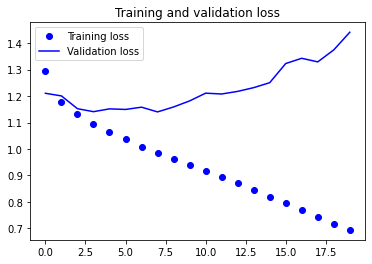

In [25]:
# Plot the Training and Validation Accuracy & Loss Scores
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Fine-Tuning Model 

In [216]:
# Build the Model
tmodel = Sequential()
tmodel.add(Embedding(max_features, embedding_dim, input_length=maxlen))
tmodel.add(LSTM(16, kernel_regularizer=regularizers.l2(0.1), return_sequences=True))
tmodel.add(layers.Dropout(0.5))
tmodel.add(LSTM(16, kernel_regularizer=regularizers.l2(0.1), return_sequences=True))
tmodel.add(layers.Dropout(0.5))
tmodel.add(GRU(16, kernel_regularizer=regularizers.l2(0.1)))
tmodel.add(layers.Dropout(0.5))
tmodel.add(Dense(5, activation='softmax'))

tmodel.layers[0].set_weights([embedding_matrix])
#tmodel.layers[0].trainable = False

tmodel.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
tmodel.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_36 (Embedding)     (None, 30, 50)            758750    
_________________________________________________________________
lstm_70 (LSTM)               (None, 30, 16)            4288      
_________________________________________________________________
dropout_94 (Dropout)         (None, 30, 16)            0         
_________________________________________________________________
lstm_71 (LSTM)               (None, 30, 16)            2112      
_________________________________________________________________
dropout_95 (Dropout)         (None, 30, 16)            0         
_________________________________________________________________
gru_36 (GRU)                 (None, 16)                1632      
_________________________________________________________________
dropout_96 (Dropout)         (None, 16)              

In [217]:
# Train the Model
thistory = tmodel.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2)

Train on 14207 samples, validate on 3552 samples
Epoch 1/20


14207/14207 [==============================] - 19s 1ms/sample - loss: 2.9692 - acc: 0.4295 - val_loss: 1.3376 - val_acc: 0.5039
Epoch 2/20
14207/14207 [==============================] - 10s 694us/sample - loss: 1.3207 - acc: 0.5180 - val_loss: 1.2845 - val_acc: 0.5166
Epoch 3/20
14207/14207 [==============================] - 10s 733us/sample - loss: 1.2608 - acc: 0.5294 - val_loss: 1.2750 - val_acc: 0.5220
Epoch 4/20
14207/14207 [==============================] - 11s 771us/sample - loss: 1.2344 - acc: 0.5323 - val_loss: 1.2344 - val_acc: 0.5225
Epoch 5/20
14207/14207 [==============================] - 11s 788us/sample - loss: 1.2150 - acc: 0.5364 - val_loss: 1.2370 - val_acc: 0.5253
Epoch 6/20
14207/14207 [==============================] - 11s 766us/sample - loss: 1.1960 - acc: 0.5414 - val_loss: 1.2263 - val_acc: 0.5245
Epoch 7/20
14207/14207 [==============================] - 11s 786us/sample - loss: 1.1873 - acc: 0.5443 - val_loss: 1.2227 - val_acc: 0.5265
Epoch 8/20
14207/14207 [==

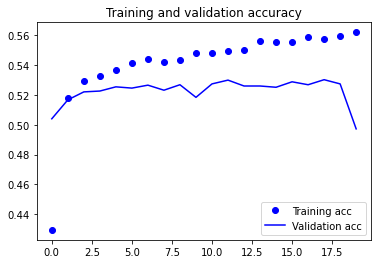

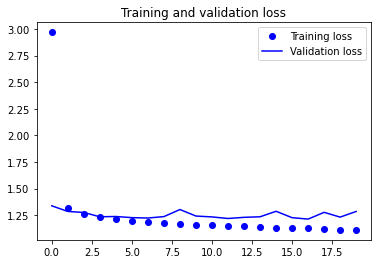

In [218]:
# Plot the Training and Validation Accuracy & Loss Scores
%matplotlib inline

acc = thistory.history['acc']
val_acc = thistory.history['val_acc']
loss = thistory.history['loss']
val_loss = thistory.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [219]:
tmodel.save('text_testmodel_4.h5')

In [220]:
tmodel.load_weights('text_testmodel_4.h5')
tmodel.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

test_loss, test_acc = tmodel.evaluate(X_test, y_test, batch_size=32, verbose=0)
print('test acc:', test_acc)

test acc: 0.50405407


### Model # 4.1  (Student Name: Brayden)(Final Model)

In [81]:
# Build the Model
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
model.add(LSTM(8, kernel_regularizer=regularizers.l1(0.0001), return_sequences=True))
model.add(layers.Dropout(0.5))
model.add(LSTM(8, kernel_regularizer=regularizers.l1(0.0001), return_sequences=True))
model.add(layers.Dropout(0.5))
model.add(GRU(8, kernel_regularizer=regularizers.l1(0.0001)))
model.add(layers.Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 30, 50)            758750    
_________________________________________________________________
lstm_18 (LSTM)               (None, 30, 8)             1888      
_________________________________________________________________
dropout_18 (Dropout)         (None, 30, 8)             0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 30, 8)             544       
_________________________________________________________________
dropout_19 (Dropout)         (None, 30, 8)             0         
_________________________________________________________________
gru_9 (GRU)                  (None, 8)                 432       
_________________________________________________________________
dropout_20 (Dropout)         (None, 8)                

In [82]:
# Train the Model
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2)

Train on 14207 samples, validate on 3552 samples
Epoch 1/20


14207/14207 [==============================] - 22s 2ms/sample - loss: 1.5233 - acc: 0.3866 - val_loss: 1.3830 - val_acc: 0.4778
Epoch 2/20
14207/14207 [==============================] - 9s 634us/sample - loss: 1.3667 - acc: 0.4954 - val_loss: 1.3051 - val_acc: 0.5011
Epoch 3/20
14207/14207 [==============================] - 9s 645us/sample - loss: 1.3109 - acc: 0.5107 - val_loss: 1.2811 - val_acc: 0.5065
Epoch 4/20
14207/14207 [==============================] - 10s 697us/sample - loss: 1.2888 - acc: 0.5138 - val_loss: 1.2689 - val_acc: 0.5065
Epoch 5/20
14207/14207 [==============================] - 10s 672us/sample - loss: 1.2699 - acc: 0.5174 - val_loss: 1.2714 - val_acc: 0.5090
Epoch 6/20
14207/14207 [==============================] - 9s 627us/sample - loss: 1.2639 - acc: 0.5175 - val_loss: 1.2538 - val_acc: 0.5113
Epoch 7/20
14207/14207 [==============================] - 11s 746us/sample - loss: 1.2549 - acc: 0.5247 - val_loss: 1.2589 - val_acc: 0.5099
Epoch 8/20
14207/14207 [=====

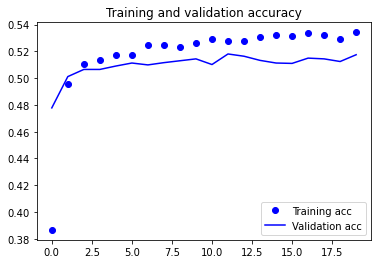

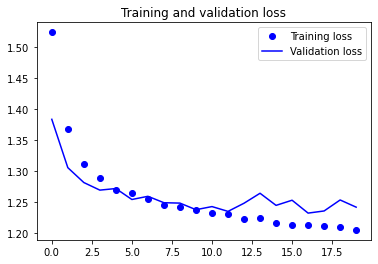

In [83]:
# Plot the Training and Validation Accuracy & Loss Scores
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [84]:
# Save the Model [change the file model number]
model.save('text_model_4.h5')

In [187]:
model.save('text_model_4_Brayden.h5')

## Step 3 – Evaluate the Model using Testing Data (Individual & Group)

In [ ]:
# Model #1 (replicate where necessary for other models)
model.load_weights('text_model_1.h5')


In [ ]:
# Model #2 (replicate where necessary for other models)
model.load_weights('text_model_2.h5')


In [ ]:
# Model #3 (replicate where necessary for other models)
model.load_weights('text_model_3.h5')


In [188]:
# Model #4 (replicate where necessary for other models)
model.load_weights('text_model_4_Brayden.h5')
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=32, verbose=0)
print('test acc:', test_acc)

test acc: 0.5315315


In [ ]:
# Model #5 (replicate where necessary for other models)
model.load_weights('text_model_5.h5')


## Step 4 – Use the Best Model to make prediction (Group)

In [ ]:
# Model #2 (replicate where necessary for other models)
model.load_weights('text_model_2.h5')


In [180]:
model.load_weights('text_model_4.h5')

In [186]:
# takes the user input

In [185]:
# convert the user input into numeric tensor


In [184]:
# show the model output using predict function
